In [27]:
# Setup & import
import os, zipfile, shutil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

# Unzip dataset
zip_path = "/content/weld-defect-dataset.zip"
extract_path = "/content/weld_data"

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# define class
class WeldDefectDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = sorted([
            os.path.join(self.image_dir, fname)
            for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.label_paths = [
            os.path.join(self.label_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        image = Image.open(img_path).convert("RGB")

        with open(label_path, 'r') as f:
            first_line = f.readline().strip()
            if not first_line:
                label = 0
            else:
                label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
train_accs, val_accs = [], []
for epoch in range(25):
    model.train()
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    train_accs.append(correct / total)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1} - Train Acc: {train_accs[-1]*100:.2f}%, Val Acc: {val_accs[-1]*100:.2f}%")

Epoch 1 - Train Acc: 47.27%, Val Acc: 58.96%
Epoch 2 - Train Acc: 54.34%, Val Acc: 64.74%
Epoch 3 - Train Acc: 56.08%, Val Acc: 61.27%
Epoch 4 - Train Acc: 56.33%, Val Acc: 56.07%
Epoch 5 - Train Acc: 59.43%, Val Acc: 43.35%
Epoch 6 - Train Acc: 58.81%, Val Acc: 46.24%
Epoch 7 - Train Acc: 60.17%, Val Acc: 54.34%
Epoch 8 - Train Acc: 59.93%, Val Acc: 52.02%
Epoch 9 - Train Acc: 58.81%, Val Acc: 67.05%
Epoch 10 - Train Acc: 66.00%, Val Acc: 66.47%
Epoch 11 - Train Acc: 67.25%, Val Acc: 57.23%
Epoch 12 - Train Acc: 61.54%, Val Acc: 42.77%
Epoch 13 - Train Acc: 65.26%, Val Acc: 56.65%
Epoch 14 - Train Acc: 66.00%, Val Acc: 67.63%
Epoch 15 - Train Acc: 67.49%, Val Acc: 65.90%
Epoch 16 - Train Acc: 66.63%, Val Acc: 66.47%
Epoch 17 - Train Acc: 71.96%, Val Acc: 61.27%
Epoch 18 - Train Acc: 70.47%, Val Acc: 69.36%
Epoch 19 - Train Acc: 71.46%, Val Acc: 49.13%
Epoch 20 - Train Acc: 68.24%, Val Acc: 58.38%
Epoch 21 - Train Acc: 72.33%, Val Acc: 64.74%
Epoch 22 - Train Acc: 74.19%, Val Acc: 68.7

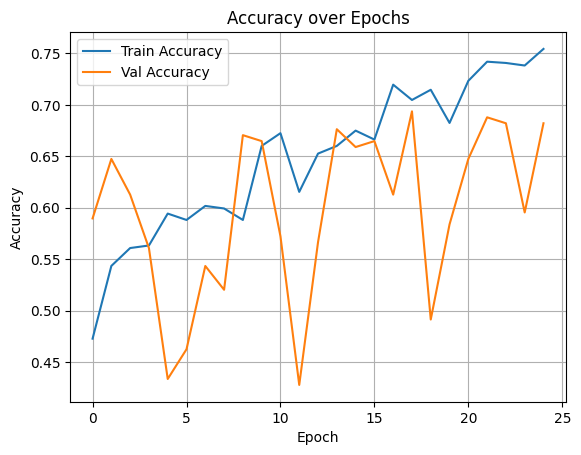

In [30]:
#accuracy curve
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#evalute validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

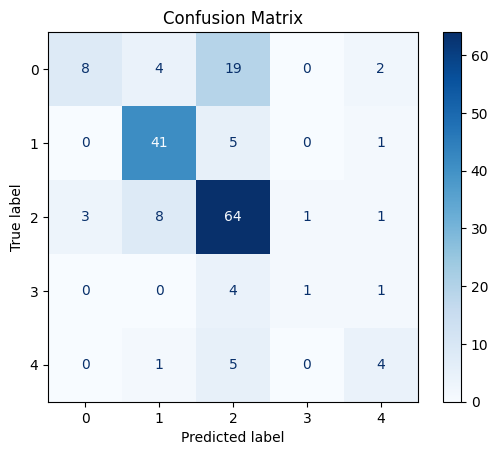

In [32]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [33]:
# Accuracy per class
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
class_counts = np.bincount(all_labels)
correct_per_class = np.bincount(all_labels[all_preds == all_labels], minlength=5)
acc_per_class = (correct_per_class / class_counts) * 100

for i, acc in enumerate(acc_per_class):
    print(f"Class {i} Accuracy: {acc:.2f}%")

Class 0 Accuracy: 24.24%
Class 1 Accuracy: 87.23%
Class 2 Accuracy: 83.12%
Class 3 Accuracy: 16.67%
Class 4 Accuracy: 40.00%


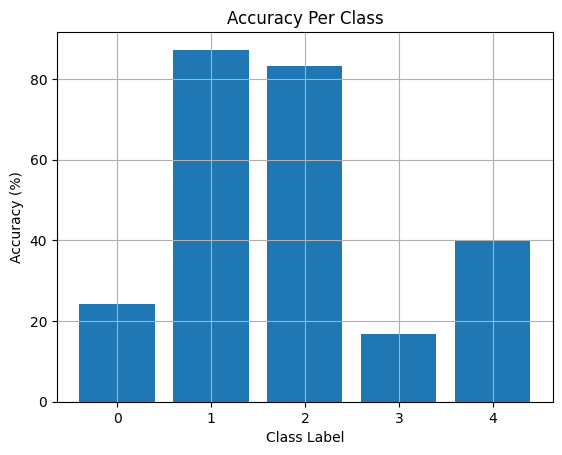

In [34]:
#Bar plot
plt.bar(range(5), acc_per_class)
plt.title("Accuracy Per Class")
plt.xlabel("Class Label")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(5))
plt.show()

In [35]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

In [36]:
#split dataset train/validation/test
full_dataset = WeldDefectDataset(image_dir, label_dir, transform=None)

targets = [full_dataset[i][1] for i in range(len(full_dataset))]

from sklearn.model_selection import train_test_split

train_idx, temp_idx = train_test_split(range(len(targets)), test_size=0.3, stratify=targets)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[targets[i] for i in temp_idx])

#create dataloader
train_dataset = Subset(WeldDefectDataset(image_dir, label_dir, transform=train_transform), train_idx)
val_dataset = Subset(WeldDefectDataset(image_dir, label_dir, transform=val_test_transform), val_idx)
test_dataset = Subset(WeldDefectDataset(image_dir, label_dir, transform=val_test_transform), test_idx)

In [37]:
#hyperparameter tuning
learning_rates = [1e-2, 1e-3, 1e-4]
results = {}

#resNet18
for lr in learning_rates:
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
#train model
    train_accs, val_accs = [], []
    for epoch in range(10):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
        train_accs.append(correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
        val_accs.append(correct / total)
    results[lr] = (train_accs[-1], val_accs[-1])
    print(f"LR={lr} | Epoch {epoch+1} | Train Acc={train_accs[-1]:.4f} | Val Acc={val_accs[-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


LR=0.01 | Epoch 10 | Train Acc=0.6005 | Val Acc=0.3699
LR=0.001 | Epoch 10 | Train Acc=0.6650 | Val Acc=0.2254
LR=0.0001 | Epoch 10 | Train Acc=0.7457 | Val Acc=0.7225



Final Test Accuracy: 76.30%


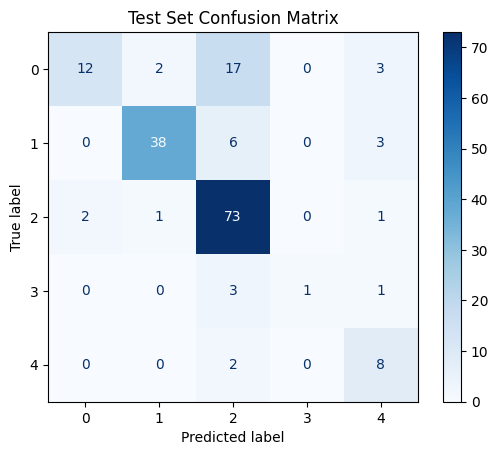


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.35      0.50        34
           1       0.93      0.81      0.86        47
           2       0.72      0.95      0.82        77
           3       1.00      0.20      0.33         5
           4       0.50      0.80      0.62        10

    accuracy                           0.76       173
   macro avg       0.80      0.62      0.63       173
weighted avg       0.80      0.76      0.74       173



In [39]:
from sklearn.metrics import classification_report

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
all_preds, all_labels = [], []
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
#confusion matrix and classification report on test
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Test Set Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=2))